In [ ]:
!pip install torchsummary

## Import Libraries

In [ ]:
import os
import time
import numpy as np
import pandas as pd

import zipfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Ignore all warnings
warnings.filterwarnings("ignore", category=Warning)

from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight

## Setting the device to GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Extracting Validation Images

In [ ]:
# Define the path to the zip file (adjust the path as necessary)
val_zip_path = '/kaggle/input/ifood-2019-fgvc6/val_set.zip'

# Define the directory where you want to extract the contents
extract_dir = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['train_set', 'val_set']


## Extracting Train images

In [ ]:
# the path to the zip file
train_zip_path = '/kaggle/input/ifood-2019-fgvc6/train_set.zip'

# the directory where we want to extract the contents
extract_dir = '/kaggle/working/extracted_files'

# Create the extraction directory if it does not exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
    print(f'Extracted all files to {extract_dir}')

# Verify extraction
extracted_files = os.listdir(extract_dir)
print('Extracted files:', extracted_files)

Extracted all files to /kaggle/working/extracted_files
Extracted files: ['train_set', 'val_set']


In [ ]:
# Check the count of images in train set
train_files = os.listdir( extract_dir + '/train_set' )
print(f'Number of train images = {len(train_files)}')

# Check the count of images in validation set
val_files = os.listdir( extract_dir + '/val_set' )
print(f'Number of validation images = {len(val_files)}')

Number of train images = 118475
Number of validation images = 11994


In [ ]:
### READ LABLES ANNOTATIONS FILE AND CONVERT IT INTO DICTIONARY
annot = '/kaggle/input/ifood-2019-fgvc6/class_list.txt'
f = open( annot, "r" )
labels_dict = { int(x.split(' ')[0]) : x.split(' ')[1].split('\n')[0] for x in f }

######################################################################################
######################################################################################

In [ ]:
## Read train df
train_df = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/train_labels.csv' )
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_101733.jpg,211
1,train_101734.jpg,211
2,train_101735.jpg,211
3,train_101736.jpg,211
4,train_101737.jpg,211
5,train_101738.jpg,211


In [ ]:
# Shuffle DataFrame rows
train_df = train_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
train_df.head(6)

(118475, 2)


,img_name,label
0,train_031749.jpg,33
1,train_052325.jpg,168
2,train_063856.jpg,63
3,train_051649.jpg,210
4,train_007268.jpg,88
5,train_009117.jpg,9


## Plotting the class distribution

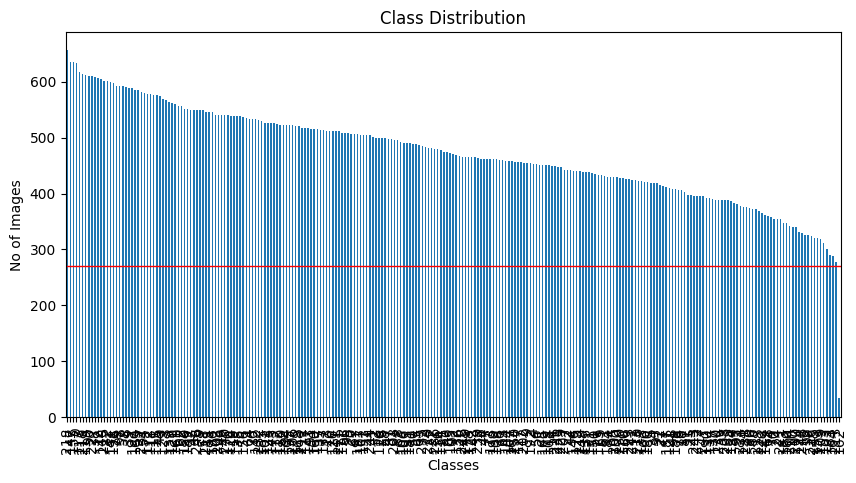

In [ ]:
no_of_samples_per_class = 270
plt.figure( figsize = (10, 5) )
train_df['label'].value_counts().plot( kind = 'bar' )
plt.xlabel('Classes')
plt.ylabel('No of Images')
plt.title('Class Distribution')
# Draw a horizontal line at y = 100
plt.axhline( y = no_of_samples_per_class, color = 'r', linestyle = '-', linewidth = 1 )
plt.show()

In [ ]:
### 162 CLASS HAS ONLY 34 DATA ITEMS, WILL DROP THIS

train_df[train_df['label'] == 162].shape

(34, 2)

In [ ]:
### 251 TOTAL CLASSES
len(train_df['label'].unique())

251

## Class Balancing -- Taking only 270 samples per class

In [ ]:
### HERE WE ARE TAKING 270 IMAGES FOR EACH CLASS AND DROPPING THE CLASS WITH < 270 IMAGES

def take_samples_per_class( train_df, no_of_samples ):
    dropped_columns = []
    df = pd.DataFrame()
    for i in range(251):
        if train_df[ train_df['label'] == i ].shape[0] >= no_of_samples:
            df_ = train_df[ train_df['label'] == i ].iloc[:no_of_samples]
            df  = pd.concat( [df, df_], ignore_index = True )
        else:
            # print('Dropped class -- ',i,'--',labels_dict[i])
            dropped_columns.append(i)
    return df, dropped_columns

df, dropped_columns = take_samples_per_class( train_df, no_of_samples_per_class )
print(f'Dropped columns = {dropped_columns}')
print(df.shape)
df.head(3)

Dropped columns = [162]
(67500, 2)


,img_name,label
0,train_059651.jpg,0
1,train_059522.jpg,0
2,train_059486.jpg,0


In [ ]:
# Shuffle DataFrame rows
df = df.sample(frac=1).reset_index(drop=True)
df.head(6)

,img_name,label
0,train_095426.jpg,89
1,train_094767.jpg,74
2,train_019801.jpg,57
3,train_023971.jpg,24
4,train_111134.jpg,230
5,train_118206.jpg,246


In [ ]:
###  TOTAL CLASSES AFTER CLASS BALANCING 250
num_classes = len(df['label'].unique())
num_classes

250

In [ ]:
## WE DROPPED 162 CLASS, NOW WE HAVE TO ADJUST THE LABELS
sorted(df['label'].unique())[160:174]

[160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]

In [ ]:
# Function to adjust labels
def adjust_labels(label):
    if label >= 163:
        return label - 1
    else:
        return label

df['labels'] = df['label'].apply(adjust_labels)
sorted(df['labels'].unique())[160:174]

[160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]

In [ ]:
print(len(df['label'].unique()))
df.head(2)

250


,img_name,label,labels
0,train_095426.jpg,89,89
1,train_094767.jpg,74,74


## Train and Validation split

In [ ]:
## HERE WE ARE TAKING THE VALIDATION DATA DROM TRAIN SET
def train_and_val_split_func( df ):
    train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['labels'], random_state=42)
    print(f'train set  = {train_df.shape} --- {(train_df.shape[0]/df.shape[0])*100}')
    print(f'valid set  = {val_df.shape} --- {(val_df.shape[0]/df.shape[0])*100}')

    return train_df.reset_index().drop('index', axis =1), val_df.reset_index().drop('index', axis =1)

In [ ]:
## Preprocessing test df
test_df_ = pd.read_csv( '/kaggle/input/ifood-2019-fgvc6/val_labels.csv' )
test_df_ = test_df_[ test_df_['label'] != 162 ] ### DROP 162 CLASS

print('Before Processing: ',sorted(test_df_['label'].unique())[160:174])
test_df_['labels'] = test_df_['label'].apply(adjust_labels) ## fix the classes
print('After Processing:  ',sorted(test_df_['labels'].unique())[160:174])

Before Processing:  [160, 161, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174]
After Processing:   [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173]


In [ ]:
## train and validation df
train_df_, val_df_ = train_and_val_split_func( df )
print(f'test  set  = {test_df_.shape}')

train set  = (57375, 3) --- 85.0
valid set  = (10125, 3) --- 15.0
test  set  = (11945, 3)


## Data Augmentation

In [ ]:
# define transformer
resize_ = 256

transform = A.Compose([
  A.Resize( height = resize_, width = resize_ ),
  A.HorizontalFlip(  ),
  A.VerticalFlip( ),
  A.RandomRotate90(  ),
  A.Transpose( p = 1 ),
  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p = 1 ),
  A.Blur( blur_limit = 3 ),
  A.OpticalDistortion( ),
  A.GridDistortion(  ),
  A.HueSaturationValue(  ),
  A.Normalize( mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225)),
  ToTensorV2()
])

## Data Loader Class

In [ ]:
class MyDataloader(Dataset):

    def __init__(self, dir_path, labels_df, transform):
        # self.labels_df = pd.read_csv( labels_csv )
        self.labels_df = labels_df
        self.dir_path  = dir_path

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        cur_index  = self.labels_df.iloc[idx]

        img_path = os.path.join( self.dir_path, cur_index[0])  # image path
        img      = Image.open(img_path)
        ## print(f'Image shape before any transform {img.size}')
        ## original shape --> 256, 383
        img      = np.array(img)

        ## apply transform
        transformed     = transform( image = img )
        transfromed_img = transformed["image"]

        return transfromed_img.to(torch.float32), cur_index[2]

In [ ]:
train_images_path = '/kaggle/working/extracted_files/train_set'
test_images_path  = '/kaggle/working/extracted_files/val_set'

In [ ]:
## HERE -- TESTING THE DATALOADER CLASS
ds = MyDataloader( train_images_path, train_df_, transform = transform )
inp, out = ds.__getitem__( 5 )          # get first item
print(f'input shape -- {inp.shape} --- {inp.dtype}') # print shapes
print(f'output      -- {out}       --- {out.dtype}')

input shape -- torch.Size([3, 256, 256]) --- torch.float32
output      -- 104       --- int64


In [ ]:
train_ds = MyDataloader( train_images_path, train_df_, transform = transform )
print( f'trainset length -- {train_ds.__len__()}')

val_ds =  MyDataloader( train_images_path, val_df_, transform = transform )
print( f'validset length -- {val_ds.__len__()}' )

test_ds = MyDataloader( test_images_path, test_df_, transform = transform )
print( f'trainset length -- {test_ds.__len__()}')

trainset length -- 57375
validset length -- 10125
trainset length -- 11945


In [ ]:
batch_size = 120

# create train dataloader -- for parallel data loading
train_dl = torch.utils.data.DataLoader(
           train_ds,
           batch_size  = batch_size,
           drop_last   = True,
           shuffle     = True,
           num_workers = 4
)

# create validation dataloader
val_dl =  torch.utils.data.DataLoader(
          val_ds,
          batch_size  = batch_size,
          # drop_last argument drops the last non-full batch of each worker’s iterable-style dataset
          drop_last   = True,  # False
          shuffle     = False,
          # Setting the argument num_workers as a positive integer will turn on multi-process data loading
          # with the specified number of loader worker processes.
          num_workers = 4
)

# create test dataloader
test_dl = torch.utils.data.DataLoader(
  test_ds,
  batch_size = batch_size,
  # drop_last argument drops the last non-full batch of each worker’s iterable-style dataset
  drop_last = True,  # False
  shuffle = False,
  # Setting the argument num_workers as a positive integer will turn on multi-process data loading
  # with the specified number of loader worker processes.
  num_workers = 4
)

In [ ]:
## NUMBER OF TRAIN AND VALIDATION BATCHES
print(f'Num of batches in train loader   = { int(train_ds.__len__() / batch_size) }') # drop_last = True
print(f'Num of batches in valid loader   = { int(val_ds.__len__()   / batch_size) }') # drop_last = True
print(f'Num of batches in test  loader   = { int(test_ds.__len__()   / batch_size) }') # drop_last = True

Num of batches in train loader   = 478
Num of batches in valid loader   = 84
Num of batches in test  loader   = 99


In [ ]:
# Get a batch of random training images and their labels
dataiter = iter(val_dl)
images, labels = next(dataiter)
print(f'images shape: {images.shape}')
print(f'labels:       {labels.shape}')

images shape: torch.Size([120, 3, 256, 256])
labels:       torch.Size([120])


## Displaying some images

In [ ]:
# Function to display an image
def imshow(image):


    print( f'images shape -- {image.shape}' )
    mean = torch.tensor( [0.485, 0.456, 0.406] )
    std  = torch.tensor( [0.229, 0.224, 0.225] )

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

images shape -- torch.Size([3, 3872, 2066])


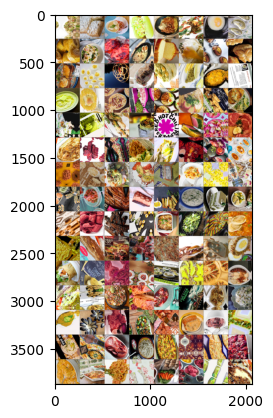

In [ ]:
imshow( torchvision.utils.make_grid( images ) )

## CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):

        super(CNN, self).__init__()

        padding = 1
        stride  = 2

        self.layer1   = nn.Conv2d( 3, 6,    kernel_size=3, stride=stride, padding=padding)
        self.layer2   = nn.BatchNorm2d(6)
        self.layer3   = nn.ReLU()

        self.layer4   = nn.Conv2d( 6, 12,   kernel_size=3, stride=stride, padding=padding)
        self.layer5   = nn.BatchNorm2d(12)
        self.layer6   = nn.ReLU()

        self.layer7   = nn.Conv2d( 12, 24,  kernel_size=3, stride=stride, padding=padding)
        self.layer8   = nn.BatchNorm2d(24)
        self.layer9   = nn.ReLU()

        self.layer10  = nn.Conv2d( 24, 48,  kernel_size=3, stride=stride, padding=padding)
        self.layer11  = nn.BatchNorm2d(48)
        self.layer12  = nn.ReLU()

        self.layer13  = nn.Conv2d( 48, 96,  kernel_size=3, stride=stride, padding=padding)
        self.layer14  = nn.BatchNorm2d(96)
        self.layer15  = nn.ReLU()

        self.layer16  = nn.Conv2d( 96, 192, kernel_size=3, stride=stride, padding=padding)
        self.layer17  = nn.BatchNorm2d(192)
        self.layer18  = nn.ReLU()

        self.fc1   = nn.Linear( 192*4*4, 250 )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = self.layer14(x)
        x = self.layer15(x)
        x = self.layer16(x)
        x = self.layer17(x)
        x = self.layer18(x)
#         print(x.shape)
        x = x.view(x.shape[0],-1)
#         print(f'x shape after view {x.shape}')
        x = self.fc1(x)
        return x


In [ ]:
### TESTING THE MODEL WITH THE FAKE INPUT
net = CNN()
net.to(device)

# create fake input and test the network
inp1 = torch.rand(24, 3, 256, 256).to(device)

# compute output
out = net(inp1)
# print(f'input  shape = {inp1.size()}')
print(f'output shape = {out.size()}')

output shape = torch.Size([24, 250])


## CNN Model Summary

In [ ]:
# Print the summary
summary( net, input_size=( 3, 256, 256 ) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 128, 128]             168
       BatchNorm2d-2          [-1, 6, 128, 128]              12
              ReLU-3          [-1, 6, 128, 128]               0
            Conv2d-4           [-1, 12, 64, 64]             660
       BatchNorm2d-5           [-1, 12, 64, 64]              24
              ReLU-6           [-1, 12, 64, 64]               0
            Conv2d-7           [-1, 24, 32, 32]           2,616
       BatchNorm2d-8           [-1, 24, 32, 32]              48
              ReLU-9           [-1, 24, 32, 32]               0
           Conv2d-10           [-1, 48, 16, 16]          10,416
      BatchNorm2d-11           [-1, 48, 16, 16]              96
             ReLU-12           [-1, 48, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]          41,568
      BatchNorm2d-14             [-1, 9

## Validation Function

In [ ]:
def validate_updated(net, dl, loss_func):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    net.eval() # Set the network in evaluation mode

    with torch.no_grad(): # Disable gradient computation during validation

        for i, data in enumerate( tqdm(dl) ):
            inp, gt = data
            gt = gt.squeeze()
            inp = inp.to(device)  # Move batch to GPU
            gt = gt.to(device)    # Move batch to GPU

            # Forward pass
            out = net(inp)

            # Compute loss
            loss = loss_func(out, gt)
            total_loss += loss.item() * inp.size(0)  # Accumulate total loss

            # Compute accuracy
            _, predicted = torch.max(out, 1)  # Get the index of the max logit
            correct_predictions += (predicted == gt).sum().item()  # Count correct predictions
            total_samples += inp.size(0)  # Accumulate total samples

    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    net.train()  # Set the network back to training mode

    return avg_loss, accuracy

## Training ...................................

In [ ]:
loss_func = nn.CrossEntropyLoss() # define loss
optimizer = torch.optim.Adam( params = net.parameters(), lr = 0.001 ) # define optimizer

scheduler = StepLR( optimizer, step_size = 5, gamma = 0.1 )

n_iter = 0
best_val_score = None
decrease = 0

fit_time = time.time()
for cur_epoch in range( 1, 100 ):
    since  = time.time()

    for i, data in enumerate( tqdm(train_dl) ):
        inp, gt = data
        gt  = gt.squeeze()
        inp = inp.to(device)      # move batch to gpu
        gt  = gt.to(device)       # move batch to gpu
        optimizer.zero_grad()     # reset gradients
        out = net(inp)            # compute output
        loss = loss_func(out, gt) # compute loss
        loss.backward()           # compute backward pass
        optimizer.step()          # update weights
        n_iter = n_iter + 1

    # Step the scheduler at the end of the epoch
    scheduler.step()

    cur_val_score, accuracy = validate_updated( net, val_dl, loss_func )       # at the end, validate model
    print(f'Epoch: {cur_epoch}, valid loss = {round(cur_val_score,3)}, valid accuracy = {round(accuracy,3)}')
    print("Time/epoch: {:.2f}m       ".format( ( time.time() - since ) / 60 ))

    #  check if it is the best model so far
    if best_val_score is None or cur_val_score < best_val_score:
        best_val_score = cur_val_score
        print('SAVING MODEL .....................')
        data = {
          'net'   : net.state_dict(),
          'opt'   : optimizer.state_dict(),
          'epoch' : cur_epoch
        }
        torch.save( data, '_best.pth')
    else:
        decrease += 1
        print(f"LOSS DOESN'T DECREASE {decrease} TIME")
        if decrease == 20:
            print(f"STOP TRAINING")
            break

    # save the last model
    data = {
        'net'   : net.state_dict(),
        'opt'   : optimizer.state_dict(),
        'epoch' : cur_epoch
    }
    torch.save( data, '_last.pth' )
print('Total time: {:.2f} m' .format( ( time.time() - fit_time ) / 60 ) )

  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 1, valid loss = 5.195, valid accuracy = 0.026
Time/epoch: 3.36m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 2, valid loss = 5.065, valid accuracy = 0.037
Time/epoch: 3.35m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 3, valid loss = 4.953, valid accuracy = 0.046
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 4, valid loss = 4.871, valid accuracy = 0.054
Time/epoch: 3.34m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 5, valid loss = 4.859, valid accuracy = 0.058
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 6, valid loss = 4.715, valid accuracy = 0.069
Time/epoch: 3.30m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 7, valid loss = 4.691, valid accuracy = 0.075
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 8, valid loss = 4.671, valid accuracy = 0.074
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 9, valid loss = 4.669, valid accuracy = 0.075
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 10, valid loss = 4.668, valid accuracy = 0.077
Time/epoch: 3.32m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 11, valid loss = 4.65, valid accuracy = 0.079
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 12, valid loss = 4.648, valid accuracy = 0.08
Time/epoch: 3.36m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 13, valid loss = 4.638, valid accuracy = 0.08
Time/epoch: 3.34m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 14, valid loss = 4.638, valid accuracy = 0.08
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 15, valid loss = 4.637, valid accuracy = 0.078
Time/epoch: 3.33m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 16, valid loss = 4.627, valid accuracy = 0.083
Time/epoch: 3.31m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 17, valid loss = 4.629, valid accuracy = 0.078
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 1 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 18, valid loss = 4.638, valid accuracy = 0.075
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 2 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 19, valid loss = 4.639, valid accuracy = 0.079
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 3 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 20, valid loss = 4.637, valid accuracy = 0.08
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 4 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 21, valid loss = 4.639, valid accuracy = 0.076
Time/epoch: 3.33m       
LOSS DOESN'T DECREASE 5 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 22, valid loss = 4.632, valid accuracy = 0.08
Time/epoch: 3.29m       
LOSS DOESN'T DECREASE 6 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 23, valid loss = 4.639, valid accuracy = 0.08
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 7 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 24, valid loss = 4.648, valid accuracy = 0.08
Time/epoch: 3.34m       
LOSS DOESN'T DECREASE 8 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 25, valid loss = 4.631, valid accuracy = 0.081
Time/epoch: 3.32m       
LOSS DOESN'T DECREASE 9 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 26, valid loss = 4.647, valid accuracy = 0.077
Time/epoch: 3.33m       
LOSS DOESN'T DECREASE 10 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 27, valid loss = 4.642, valid accuracy = 0.078
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 11 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 28, valid loss = 4.622, valid accuracy = 0.079
Time/epoch: 3.31m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 29, valid loss = 4.637, valid accuracy = 0.079
Time/epoch: 3.30m       
LOSS DOESN'T DECREASE 12 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 30, valid loss = 4.622, valid accuracy = 0.079
Time/epoch: 3.29m       
SAVING MODEL .....................


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 31, valid loss = 4.633, valid accuracy = 0.079
Time/epoch: 3.30m       
LOSS DOESN'T DECREASE 13 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 32, valid loss = 4.636, valid accuracy = 0.081
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 14 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 33, valid loss = 4.625, valid accuracy = 0.08
Time/epoch: 3.33m       
LOSS DOESN'T DECREASE 15 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 34, valid loss = 4.632, valid accuracy = 0.081
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 16 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 35, valid loss = 4.626, valid accuracy = 0.081
Time/epoch: 3.36m       
LOSS DOESN'T DECREASE 17 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 36, valid loss = 4.635, valid accuracy = 0.079
Time/epoch: 3.33m       
LOSS DOESN'T DECREASE 18 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 37, valid loss = 4.637, valid accuracy = 0.08
Time/epoch: 3.31m       
LOSS DOESN'T DECREASE 19 TIME


  0%|          | 0/478 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

Epoch: 38, valid loss = 4.625, valid accuracy = 0.08
Time/epoch: 3.34m       
LOSS DOESN'T DECREASE 20 TIME
STOP TRAINING
Total time: 126.34 m


## Evaluate the model on test set

In [ ]:
#  load best network
state = torch.load( '_best.pth' )
net.load_state_dict( state['net'] )

<All keys matched successfully>

In [ ]:
def evaluate_function_test(net, dl, loss_func):

    all_pred = []
    all_gt   = []

    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    net.eval() # Set the network in evaluation mode

    with torch.no_grad(): # Disable gradient computation during validation

        for i, data in enumerate( tqdm(dl) ):
            inp, gt = data
            gt = gt.squeeze()

            inp = inp.to(device)  # Move batch to GPU
            gt  = gt.to(device)    # Move batch to GPU

            # Forward pass
            out = net(inp)

            # Compute loss
            loss = loss_func(out, gt)
            total_loss += loss.item() * inp.size(0)  # Accumulate total loss

            # Compute accuracy
            _, pred = torch.max(out, 1)  # Get the index of the max logit
            correct_predictions += (pred == gt).sum().item()  # Count correct predictions
            total_samples += inp.size(0)  # Accumulate total samples

            all_pred.append( pred.tolist() )
            all_gt.append(   gt.tolist() )

    # Compute average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples

    net.train()  # Set the network back to training mode

    return avg_loss, accuracy, all_pred, all_gt

In [ ]:
loss, acc, out, gt = evaluate_function_test( net, test_dl, loss_func )
print(f'loss = {loss}  accuracy = {acc}')

  0%|          | 0/99 [00:00<?, ?it/s]

loss = 4.4796435616233135  accuracy = 0.09335016835016835


In [ ]:
pred_all = torch.tensor([ p for pred in out for p in pred ])
gt_all   = torch.tensor([ p for pred in gt for p in pred ])

print(f'Length of pred: {len(pred_all)}') # 11940
print(f'Length of   gt: {len(gt_all)}')   # 11940

Length of pred: 11880
Length of   gt: 11880


## Classification Report

In [ ]:
# Compute classification report
report = classification_report(gt_all, pred_all, labels=np.arange(250))
lines = report.split('\n')

In [ ]:
lines[:10]

['              precision    recall  f1-score   support',
 '',
 '           0       0.07      0.05      0.06        55',
 '           1       0.13      0.26      0.18        61',
 '           2       0.06      0.04      0.04        53',
 '           3       0.08      0.14      0.10        51',
 '           4       0.12      0.05      0.07        41',
 '           5       0.07      0.12      0.09        51',
 '           6       0.04      0.02      0.03        56',
 '           7       0.05      0.02      0.03        54']

In [ ]:
class_results = {}
for line in lines[2:-5]:  # skip header and footer lines
    line_data = line.split()
    if len(line_data) > 0:

        class_id  = int(line_data[0])
        precision = float(line_data[1])
        recall    = float(line_data[2])
        f1_score  = float(line_data[3])
        support   = float(line_data[4])

        class_results[class_id] = {
            'precision': precision,
            'recall': recall,
            'f1-score': f1_score,
            'support': support
            }

### Sorting the classification score matrix on the basis of F-1 score

In [ ]:
# class_results

# Example: Print classes with highest and lowest F1-score
best_classes  = sorted( class_results.items(), key = lambda x: x[1]['f1-score'], reverse=True)[:10]
worst_classes = sorted( class_results.items(), key = lambda x: x[1]['f1-score'])[:10] # 56

print("\nClasses with best results (highest F1-score):")
for class_id, metrics in best_classes:
    print(f"Class {class_id}: F1-score = {metrics['f1-score']:.4f}")

print("\nClasses with worst results (lowest F1-score):")
for class_id, metrics in worst_classes:
    print(f"Class {class_id}: F1-score = {metrics['f1-score']:.4f}")


Classes with best results (highest F1-score):
Class 60: F1-score = 0.3200
Class 68: F1-score = 0.3100
Class 190: F1-score = 0.3000
Class 27: F1-score = 0.2500
Class 82: F1-score = 0.2500
Class 89: F1-score = 0.2500
Class 15: F1-score = 0.2300
Class 63: F1-score = 0.2300
Class 45: F1-score = 0.2200
Class 177: F1-score = 0.2000

Classes with worst results (lowest F1-score):
Class 12: F1-score = 0.0000
Class 14: F1-score = 0.0000
Class 18: F1-score = 0.0000
Class 33: F1-score = 0.0000
Class 40: F1-score = 0.0000
Class 44: F1-score = 0.0000
Class 50: F1-score = 0.0000
Class 54: F1-score = 0.0000
Class 58: F1-score = 0.0000
Class 59: F1-score = 0.0000


## Confusion Matrix of Classes with best F-1 score

In [ ]:
def display_confusion_matrix(ground_truths, predicted_labels, class_labels=None):
    # Compute confusion matrix
    cm = confusion_matrix(ground_truths, predicted_labels, labels=class_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
best_classes_predictions = [class_id for class_id, metrics in best_classes][:20]

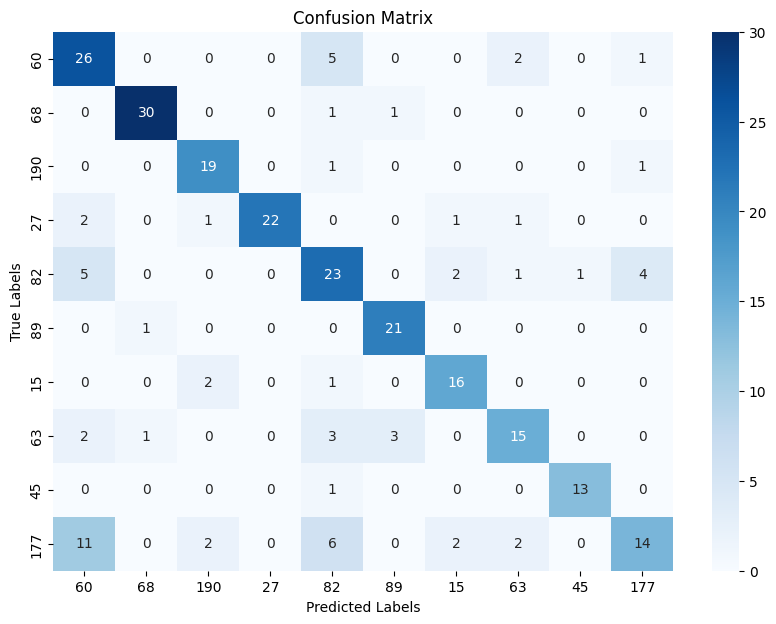

In [ ]:
display_confusion_matrix(gt_all, pred_all, best_classes_predictions)

## Confusion Matrix of Classes with worst F-1 score

In [ ]:
worst_classes_predictions = [class_id for class_id, metrics in worst_classes][:20]

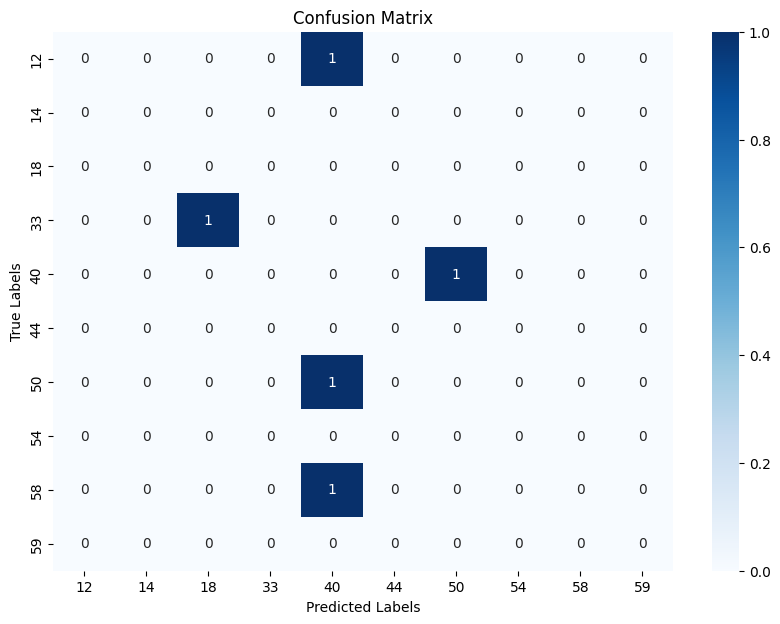

In [ ]:
display_confusion_matrix(gt_all, pred_all, worst_classes_predictions)